In [3]:
bond_dim=24
iLayer=30

path_dir='./data/' if bond_dim==24 else './data/X{0}/'.format(bond_dim)
path_dir_layers='./data/layers/' if bond_dim==24 else './data/X{0}/'.format(bond_dim)

filename1=path_dir+'hotrg_gilt_X{0}.pth'.format(bond_dim)
filename2=path_dir_layers+'hotrg_gilt_X{0}_lTRG_gilt_L{1}.pth'.format(bond_dim,iLayer)
filename_lattice=path_dir_layers+'hotrg_gilt_X{0}_lTRG_gilt_L{1}_lattice.pth'.format(bond_dim,iLayer)
filename_txt=path_dir_layers+'hotrg_gilt_X{0}_lTRG_gilt_L{1}_output.txt'.format(bond_dim,iLayer)
filename_prefix_figures=path_dir_layers+'hotrg_gilt_X{0}_lTRG_gilt_L{1}_'.format(bond_dim,iLayer)

# filename1='./data/hotrg_X24.pth'
# filename2='./data/hotrg_X24_lTRG_L20.pth'

print('results will be summarized to',filename_txt)
def fprint(*args):
    with open(filename_txt,'a') as f:
        print(*args,file=f)
with open(filename_txt,'w') as f:
    print('bond_dim',bond_dim,'iLayer',iLayer,file=f)

results will be summarized to ./data/layers/hotrg_gilt_X24_lTRG_gilt_L30_output.txt


In [4]:
from opt_einsum import contract
import torch
torch.set_default_tensor_type(torch.cuda.DoubleTensor)
device=torch.device('cuda:0')
torch.cuda.set_device(device)
import numpy as np
from LTRG import get_scaling_dimensions_from_spectrum
from HOTRG import forward_observable_tensors, forward_layer
from TNModels import Ising2D
from tqdm.auto import tqdm
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib.colors import hsv_to_rgb

/home/wenhan/anaconda3/envs/tf-gpu/lib/python3.9/site-packages/torch/cuda/__init__.py:497: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


In [5]:
print('loading coarse-grained tensors...')

loaded_dict=torch.load(filename1,map_location=device)
options,params,layers,Ts,logTotals=loaded_dict['options'],loaded_dict['params'],loaded_dict['layers'],loaded_dict['Ts'],loaded_dict['logTotals']
T0_op,checkerboard=Ising2D(params).get_observable('magnetization')

def forward_sigmas(positions):
    T_op=forward_observable_tensors(Ts[0],[T0_op]*len(positions),positions,layers[:20],checkerboard=checkerboard,cached_Ts=Ts,user_tqdm=False)[1]
    #T_op=T_op/T_op.norm()
    return T_op

print('done')


loading coarse-grained tensors...
done


In [6]:
print('loading lTRG eigenvectors...')

options1,s_ltrg,u_ltrg=torch.load(filename2,map_location=device)
# if not torch.isclose(u_ltrg[:,:12].imag,torch.tensor(0.)).all():
#     print('Warning: u_ltrg[:,:12] is not real',torch.max(u_ltrg[:,:12].imag).cpu().item())
# u_ltrg=u_ltrg.real
#u_ltrg_backup=u_ltrg.clone()
# for i in range(0,u_ltrg.shape[1]):
#     for j in range(0,i):
#         u_ltrg[:,i]=u_ltrg[:,i]-u_ltrg[:,j]@u_ltrg[:,i]*u_ltrg[:,j]
#     u_ltrg[:,i]=u_ltrg[:,i]/u_ltrg[:,i].norm()
#assert torch.isclose(u_ltrg[:,:12],u_ltrg_backup[:,:12]).all()

scd_ltrg=get_scaling_dimensions_from_spectrum(s_ltrg.abs(),scaling=2)
scd_ltrg_labels=[f'{x:.3f}' for x in scd_ltrg]
print('Scaling Dimensions:',scd_ltrg[:64].cpu().numpy())
# print(s_ltrg.angle())

fprint('Scaling Dimensions:',scd_ltrg[:64].cpu().numpy())


u_ltrg_inv=torch.linalg.pinv(u_ltrg).T.conj()

# orthogonalize u_ltrg
u_ltrg_orth=u_ltrg.clone()
for i in range(0,u_ltrg.shape[1]):
    for j in range(0,i):
        u_ltrg_orth[:,i]=u_ltrg_orth[:,i]-u_ltrg_orth[:,j]@u_ltrg_orth[:,i]*u_ltrg_orth[:,j]

u_ltrg_useit_dualbasis=u_ltrg_inv
u_ltrg_useit_basis=u_ltrg

loading lTRG eigenvectors...
Scaling Dimensions: [0.         0.12750707 1.00213945 1.12643275 1.14458753 1.99805785
 2.00083365 2.00330845 2.04466071 2.11965019 2.19866096 2.20305291
 2.50098619 2.68448166 2.68448166 2.79110286 2.8227927  2.82643932
 2.84797979 2.84797979 3.01531513 3.09525194 3.10567327 3.10567327
 3.11734869 3.11734869 3.16122224 3.16122224 3.20117956 3.20117956
 3.2064882  3.22505561]


In [7]:
def project_out(T,Ys):
    for Y in Ys:
        T=T-contract('ijkl,ijkl->',T,Y)*Y/contract('ijkl,ijkl->',Y,Y)
    return T/T.norm()


# Lattice Operators

In [8]:
# define the lattice operators
def get_lattice_operators():
    scan=[511-200,511-100,512+100,512+200]
    scan1=[50,100,200]
    id=project_out(forward_sigmas([]),[])
    id=id/id.norm()
    sig_raw=0
    for x in scan:
        for y in scan:
            sig_raw+=forward_sigmas([(x,y)])
    sig=project_out(sig_raw,[id])
    sig=sig/sig.norm()

    sigsig_raw,sigsigsig_raw,eps,dx_sig,dy_sig,dxx_sig,dyy_sig=0,0,0,0,0,0,0
    for x in scan:
        for dx in scan1:
            L,R=511-dx,512+dx
            ML,MR=511-dx+dx//5,512+dx-dx//5
            # eps+=project_out(forward_sigmas([(x,L),(x,R)]),[id])
            # eps+=project_out(forward_sigmas([(L,x),(R,x)]),[id])
            sigsig_raw+=forward_sigmas([(x,L),(x,R)])
            sigsig_raw+=forward_sigmas([(L,x),(R,x)])
            for M in [511,512]:
                sigsigsig_raw+=forward_sigmas([(x,ML),(x,M),(x,MR)])
                sigsigsig_raw+=forward_sigmas([(ML,x),(M,x),(MR,x)])
            dx_sig+=project_out(forward_sigmas([(R,x)])-forward_sigmas([(L,x)]),[sig])
            dy_sig+=project_out(forward_sigmas([(x,R)])-forward_sigmas([(x,L)]),[sig])
            dxx_sig+=project_out(forward_sigmas([(R,x)])-forward_sigmas([(MR,x)])-forward_sigmas([(ML,x)])+forward_sigmas([(L,x)]),[sig])
            dyy_sig+=project_out(forward_sigmas([(x,R)])-forward_sigmas([(x,MR)])-forward_sigmas([(x,ML)])+forward_sigmas([(x,L)]),[sig])
    eps=project_out(sigsig_raw,[id])
    eps=eps/eps.norm()
    Tplus,Tcross,dx_eps,dy_eps,dxy_sig=0,0,0,0,0
    for dx in scan1:
        L,R=511-dx,512+dx
        Tcross+=project_out(forward_sigmas([(R,R),(L,L)])-forward_sigmas([(L,R),(R,L)]),[id,eps])
        dx_eps+=project_out(forward_sigmas([(R,L),(R,R)])-forward_sigmas([(L,L),(L,R)]),[id])
        dy_eps+=project_out(forward_sigmas([(L,R),(R,R)])-forward_sigmas([(L,L),(R,L)]),[id])
        dxy_sig+=project_out(forward_sigmas([(R,R)])-forward_sigmas([(R,L)])-forward_sigmas([(L,R)])+forward_sigmas([(L,L)]),[sig])
        for M in [511,512]:
            Tplus+=project_out(forward_sigmas([(R,M),(L,M)])-forward_sigmas([(M,L),(M,R)]),[id,eps])
        
    rtval={'id':id,'sig':sig,'eps':eps,'dx_sig':dx_sig,'dy_sig':dy_sig,'dx_eps':dx_eps,'dy_eps':dy_eps,'Tplus':Tplus,'Tcross':Tcross,'dxx_sig':dxx_sig,'dyy_sig':dyy_sig,'dxy_sig':dxy_sig,
           'sig_raw':sig_raw,'sigsig_raw':sigsig_raw,'sigsigsig_raw':sigsigsig_raw}
    for op in rtval:
        rtval[op]=rtval[op]/rtval[op].norm()
    return rtval
lattice_operators=get_lattice_operators()
torch.save(lattice_operators,filename_lattice)

KeyboardInterrupt: 

In [9]:

op_latex={
    'id':r'$\mathbb{1}$',
    'sig':r'$\sigma$',
    'eps':r'$\epsilon$',
    'dx_sig':r'$\partial_x\sigma$',
    'dy_sig':r'$\partial_y\sigma$',
    'dx_eps':r'$\partial_x\epsilon$',
    'dy_eps':r'$\partial_y\epsilon$',
    'Tplus':r'$T_+$',
    'Tcross':r'$T_{\times}$',
    'dxx_sig':r'$\partial_{x}^2\sigma$',
    'dyy_sig':r'$\partial_{y}^2\sigma$',
    'dxy_sig':r'$\partial_{x}\partial_{y}\sigma$',
}

lattice_operators=torch.load(filename_lattice, map_location=device)

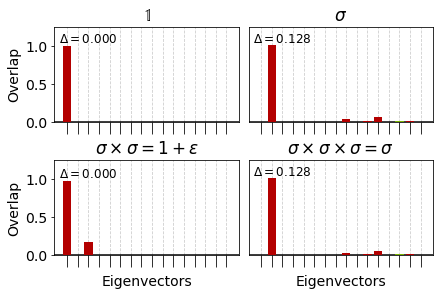

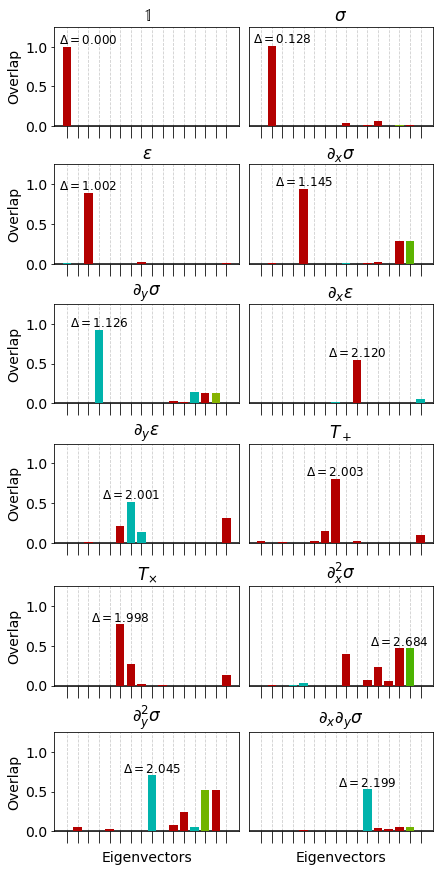

In [11]:

def show_overlap_ltrg(v_op,title='',ax=None,k=32,xtick=True,ytick=True):
    if ax is None:
        plt.figure(figsize=(6,2))
    else:
        plt.sca(ax)
    plt.title(title)
    plt.grid(axis='x',color='k',alpha=.2,zorder=0,linestyle='--')

    v_op=v_op.flatten().to(torch.complex128)
    #overlap=u_ltrg_inv.T.conj()@v_op
    #overlap=u_ltrg.T.conj()@v_op
    overlap=u_ltrg_useit_dualbasis.T.conj()@v_op
    barHeight=overlap.abs().cpu().numpy()
    barAngle=np.angle(overlap.cpu().numpy())
    barSign=np.sign(overlap.real.cpu().numpy())
    plt.bar(range(k),barHeight[:k],color=plt.cm.hsv(barAngle[:k]/(2*np.pi))*[.7,.7,.7,1],zorder=3)
    # label the scdim on the biggest bar
    biggest_idx=np.argmax(barHeight)
    # plt.text(biggest_idx,barHeight[biggest_idx],'$\Delta=$'+scd_ltrg_labels[biggest_idx],ha='center',va='bottom',fontsize=12)
    # constraint the text to be inside the figure
    text_x=np.clip(biggest_idx,2,k-3)
    plt.text(text_x,barHeight[biggest_idx],'$\Delta=$'+scd_ltrg_labels[biggest_idx],ha='center',va='bottom',fontsize=12)


    if xtick: 
        plt.xlabel('Eigenvectors')
        plt.xticks(range(k),['']*k)
        # plt.xticks(range(k),scd_ltrg_labels[:k],rotation=75)
    else: 
        plt.xticks(range(k),['']*k)
    if ytick:
        plt.ylabel('Overlap')
    else: 
        plt.yticks([])
    # plt.xlim(-2,k-1+2)
    plt.ylim(0,1.25)
    plt.axhline(0,color='k')
    # add grid

def show_NPT_projections(filename=None):

    # sig=forward_sigmas([(M,M)])
    # sigsig=forward_sigmas([(M,L),(M,R)])
    # sigsigsig=forward_sigmas([(M,L),(M,M),(M,R)])
    plt.rcParams.update({'font.size': 14,'xtick.major.size':12})
    fig, axes = plt.subplots(2,2, constrained_layout=True,figsize=(6,4))
    show_overlap_ltrg(lattice_operators['id'],title=r'$\mathbb{1}$',ax=axes[0,0],k=16,xtick=False)
    show_overlap_ltrg(lattice_operators['sig_raw'],title=r'$\sigma$',ax=axes[0,1],k=16,xtick=False,ytick=False)
    show_overlap_ltrg(lattice_operators['sigsig_raw'],title=r'$\sigma\times\sigma=1+\epsilon$',ax=axes[1,0],k=16)
    show_overlap_ltrg(lattice_operators['sigsigsig_raw'],title=r'$\sigma\times\sigma\times\sigma=\sigma$',ax=axes[1,1],k=16,ytick=False)
    if filename is not None:
        plt.savefig(filename,dpi=300)
    plt.show()
# show_NPT_projections(filename_prefix_figures+'NPT_projections.png')
show_NPT_projections('./figures/NPT_projections.png')

def show_lattice_operator_projections(filename=None):
    plt.rcParams.update({'font.size': 14,'xtick.major.size':12})
    fig, axes = plt.subplots(6,2, constrained_layout=True,figsize=(6,12))
    for i,op in enumerate(op_latex.keys()):
        show_overlap_ltrg(lattice_operators[op],title=op_latex[op],ax=axes[i//2,i%2],k=16,xtick=(i//2==5),ytick=(i%2==0))
    if filename is not None:
        plt.savefig(filename,dpi=300)
    plt.show()
# show_lattice_operator_projections(filename_prefix_figures+'lattice_operator_projections.png')
show_lattice_operator_projections('./figures/lattice_operator_projections.png')


# Rotate the basis

ul.shape torch.Size([331776, 12])
u_ltrg_useit_dualbasis.shape torch.Size([331776, 32])


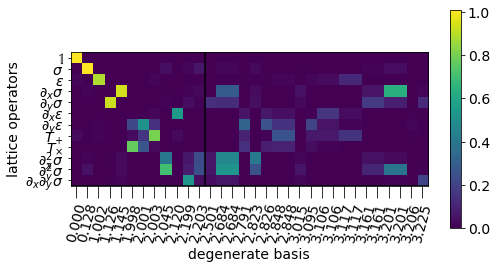

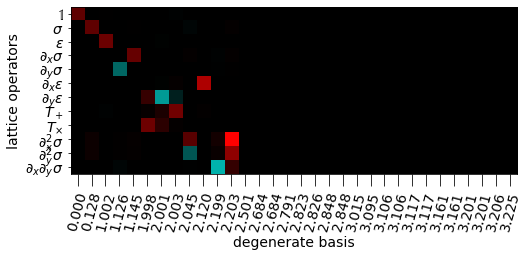

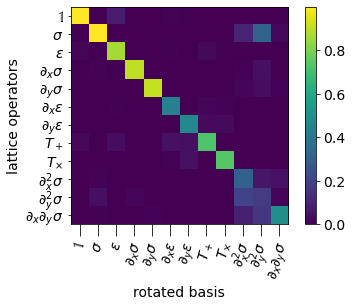

In [12]:
# rotate the degenerate basis to the basis of the lattice operators

def imshow_complex(arr,log=False):
    amp=np.log(np.abs(arr)) if log else np.abs(arr)
    amp=amp/amp.flatten().max()
    color=plt.cm.hsv(np.angle(arr)/(2*np.pi))*np.stack([amp,amp,amp,np.ones_like(amp)],axis=-1)
    plt.imshow(color)

def get_ltrg_operators(lattice_operators):
    ul=torch.stack([(T/T.norm()).flatten() for k,T in lattice_operators.items() if '_raw' not in k]).T.to(torch.complex128)
    print("ul.shape",ul.shape)
    print("u_ltrg_useit_dualbasis.shape",u_ltrg_useit_dualbasis.shape)
    gram=ul.T.conj()@u_ltrg_useit_dualbasis

    
    #rg1,rg2=[0,1,2,3,5,32],[0,1,2,3,5,12]
    #rg1,rg2=[0,1,2,3,5,9,12],[0,1,2,3,5,9,12]
    rg1,rg2=[0,12],[0,12]
    
    plt.figure(figsize=(8,4))
    plt.imshow(gram.abs().cpu().numpy())
    for i in range(len(rg1)-1):
        plt.axvline(rg1[i+1]-0.5,color='k')
        plt.axhline(rg2[i+1]-0.5,color='k')
    plt.colorbar()
    labels=[op_latex[k] for k in op_latex.keys()]
    plt.yticks(range(gram.shape[0]),labels)
    plt.xticks(range(gram.shape[1]),scd_ltrg_labels[:gram.shape[1]],rotation=75)
    plt.ylabel('lattice operators')
    plt.xlabel('degenerate basis')
    plt.show()

    rot=torch.zeros(gram.shape[1],gram.shape[0],dtype=torch.complex128)
    for i in range(len(rg1)-1):
        rot[rg2[i]:rg2[i+1],rg1[i]:rg1[i+1]]=torch.linalg.pinv(gram[rg1[i]:rg1[i+1],rg2[i]:rg2[i+1]])
    
    plt.figure(figsize=(8,4))
    imshow_complex(rot.T.cpu().numpy())
    #plt.imshow(rot.T.abs().cpu().numpy())
    #plt.colorbar()
    plt.yticks(range(gram.shape[0]),labels)
    plt.xticks(range(gram.shape[1]),scd_ltrg_labels[:gram.shape[1]],rotation=75)
    plt.ylabel('lattice operators')
    plt.xlabel('degenerate basis')
    plt.show()

    ur1=u_ltrg_useit_basis@rot

    for i in range(ur1.shape[1]):
        ur1[:,i]=ur1[:,i]/ur1[:,i].norm()

    plt.imshow((ul.T.conj()@ur1).abs().cpu().numpy())
    plt.colorbar()
    plt.yticks(range(gram.shape[0]),labels)
    plt.xticks(range(gram.shape[0]),labels,rotation=75)
    plt.ylabel('lattice operators')
    plt.xlabel('rotated basis')
    plt.show()


    return {k:(ur1[:,i]).reshape(bond_dim,bond_dim,bond_dim,bond_dim) for i,k in enumerate(op_latex.keys())}

ltrg_operators=get_ltrg_operators(lattice_operators)

# fusion of lTRG eigvecs

In [13]:



layers_sel=layers[20:22]
def CG(A,B,C,D):
    AB=forward_layer(A,B,layers_sel[0])
    CD=forward_layer(C,D,layers_sel[0])
    ABCD=forward_layer(AB,CD,layers_sel[1])
    return ABCD

def IP(A,B):
    return (A*B).sum().detach().cpu().item()

# renormalize of idop

idop=u_ltrg_useit_basis[:,0].reshape(bond_dim,bond_dim,bond_dim,bond_dim)
assert idop.imag.abs().max()<1e-10; idop=idop.real
idop=idop*(CG(idop,idop,idop,idop).norm()/idop.norm())**(-1/3)

# # verify with lTRG coroutines
# from linearized import get_linearized_HOTRG_autodiff
# from scipy.sparse.linalg import eigs
# M=get_linearized_HOTRG_autodiff(idop,layers_sel)
# eigvals,_=eigs(M,k=3,which='LR')
# eigvals=eigvals.real
# print(eigvals)
# print(eigvals/eigvals[0])
# print('scaling dimensions',-np.log2(eigvals/eigvals[0]))

idop_conj=u_ltrg_useit_dualbasis[:,0].reshape(bond_dim,bond_dim,bond_dim,bond_dim)
assert idop_conj.imag.abs().max()<1e-10; idop_conj=idop_conj.real
idop_conj=idop_conj/IP(idop_conj,idop)



print('|||idididid>||/|||id>|| is renormalized to',CG(idop,idop,idop,idop).norm()/idop.norm())

|||idididid>||/|||id>|| is renormalized to tensor(1.0000)


In [14]:
# load the other ltrg eigvecs

sig=u_ltrg_useit_basis[:,1].reshape(bond_dim,bond_dim,bond_dim,bond_dim)
eps=u_ltrg_useit_basis[:,2].reshape(bond_dim,bond_dim,bond_dim,bond_dim)
sig_conj=u_ltrg_useit_dualbasis[:,1].reshape(bond_dim,bond_dim,bond_dim,bond_dim)
eps_conj=u_ltrg_useit_dualbasis[:,2].reshape(bond_dim,bond_dim,bond_dim,bond_dim)

delta_sig=scd_ltrg[1].real.item()
delta_eps=scd_ltrg[2].real.item()
# delta_sig=0.125
# delta_eps=1

print('Δsig (eigenvalues) =',delta_sig)
print('Δeps (eigenvalues) =',delta_eps)
fprint('Δsig (eigenvalues) =',delta_sig)
fprint('Δeps (eigenvalues) =',delta_eps)

assert sig.imag.abs().max()<1e-10; sig=sig.real
assert eps.imag.abs().max()<1e-10; eps=eps.real
assert sig_conj.imag.abs().max()<1e-10; sig_conj=sig_conj.real
assert eps_conj.imag.abs().max()<1e-10; eps_conj=eps_conj.real


def shuffle_operator_positions_1pt(idop,op):
    positions=[(0,0),(0,1),(1,0),(1,1)]
    for i in range(4):
        ops=[op if k==i else idop for k in range(4)]
        pos=positions[i]
        yield ops,pos

# check the scaling dimensions of sig, eps
vals=[]
for ops,pos in shuffle_operator_positions_1pt(idop,sig):
    val=IP(sig_conj,CG(*ops))
    print(f'2^Δsig <sig|sig{pos}> =',2**delta_sig*val)
    vals.append(val)
delta_sig=np.log2(1/np.abs(np.mean(vals)))
print('Δsig (coarse graining) =',delta_sig)
fprint('Δsig (coarse graining) =',delta_sig)

vals=[]
for ops,pos in shuffle_operator_positions_1pt(idop,eps):
    val=IP(eps_conj,CG(*ops))
    print(f'2^Δeps <eps|eps{pos}> =',2**delta_eps*val)
    vals.append(val)
delta_eps=np.log2(1/np.abs(np.mean(vals)))
print('Δeps (coarse graining) =',delta_eps)
fprint('Δeps (coarse graining) =',delta_eps)

Δsig (eigenvalues) = 0.12750706847298185
Δeps (eigenvalues) = 1.0021394537693182
2^Δsig <sig|sig(0, 0)> = -0.9991327274029553
2^Δsig <sig|sig(0, 1)> = -1.000717991530061
2^Δsig <sig|sig(1, 0)> = -0.9993852432596453


2^Δsig <sig|sig(1, 1)> = -1.0012058509919033
Δsig (coarse graining) = 0.1273477268501311
2^Δeps <eps|eps(0, 0)> = 1.0013258619291436
2^Δeps <eps|eps(0, 1)> = 1.0000336439357584
2^Δeps <eps|eps(1, 0)> = 0.9984256671248106
2^Δeps <eps|eps(1, 1)> = 0.9998778911290304
Δeps (coarse graining) = 1.002260982819074


In [15]:
def shuffle_operator_positions_2pt(idop,op):
    positions=[(0,0),(0,1),(1,0),(1,1)]
    for i in range(4):
        for j in range(i+1,4):
            ops=[op if k==i or k==j else idop for k in range(4)]
            pos1,pos2=positions[i],positions[j]
            yield ops,pos1,pos2

def shuffle_operator_positions_2pt_asym(idop,op1,op2):
    positions=[(0,0),(0,1),(1,0),(1,1)]
    for i in range(4):
        for j in range(4):
            if i==j: continue
            ops=[idop]*4
            ops[i]=op1
            ops[j]=op2
            pos1,pos2=positions[i],positions[j]
            yield ops,pos1,pos2

# renormalization of sig with lattice_spacing renormalized to 1
# |O(r1)O(r2)>=C_{OOid}/r12*(2*delta_O) |O(0)> + ...
# C_{OOid} should be renormalized to 1
vals=[]#IP(idop_conj,CG(sig,sig,idop,idop))
for ops,pos1,pos2 in shuffle_operator_positions_2pt(idop,sig):
    dist=((pos1[0]-pos2[0])**2+(pos1[1]-pos2[1])**2)**.5
    val=IP(idop_conj,CG(*ops))*dist**(2*delta_sig)
    vals.append(val)
print(vals)
sig=sig*np.abs(np.average(vals))**(-1/2)
vals=[]
for ops,pos in shuffle_operator_positions_1pt(idop,sig):
    val=IP(sig_conj,CG(*ops))
    vals.append(val)
sig_conj=sig_conj/np.average(vals)

# renormalization of eps
vals=[]#IP(idop_conj,CG(eps,eps,idop,idop))
for ops,pos1,pos2 in shuffle_operator_positions_2pt(idop,eps):
    dist=((pos1[0]-pos2[0])**2+(pos1[1]-pos2[1])**2)**.5
    val=IP(idop_conj,CG(*ops))*dist**(2*delta_eps)
    vals.append(val)
print(vals)
eps=eps*np.abs(np.average(vals))**(-1/2)
vals=[]
for ops,pos in shuffle_operator_positions_1pt(idop,eps):
    val=IP(eps_conj,CG(*ops))
    vals.append(val)
eps_conj=eps_conj/np.average(vals)


print('C_sigsigid',1)
vals=[]
for ops,pos1,pos2 in shuffle_operator_positions_2pt(idop,sig):
    dist=((pos1[0]-pos2[0])**2+(pos1[1]-pos2[1])**2)**.5
    val=IP(idop_conj,CG(*ops))*dist**(2*delta_sig)
    print(f'r^(2 delta) <id|sig{pos1}sig{pos2}>=',val)
    vals.append(val)
print('average',np.average(vals))
fprint('C_sigsigid',np.average(vals))

print('C_epsepsid',1)
vals=[]
for ops,pos1,pos2 in shuffle_operator_positions_2pt(idop,eps):
    dist=((pos1[0]-pos2[0])**2+(pos1[1]-pos2[1])**2)**.5
    val=IP(idop_conj,CG(*ops))*dist**(2*delta_eps)
    print(f'r^(2 delta) <id|eps{pos1}eps{pos2}>=',val)
    vals.append(val)
print('average',np.average(vals))
fprint('C_epsepsid',np.average(vals))



print('C_sigsigsig',0)
vals=[]
for ops,pos1,pos2 in shuffle_operator_positions_2pt(idop,sig):
    dist=((pos1[0]-pos2[0])**2+(pos1[1]-pos2[1])**2)**.5
    delta=delta_sig+delta_sig-delta_sig
    val=IP(sig_conj,CG(*ops))*dist**delta
    print(f'r^(Δ+Δ-Δ) <sig|sig{pos1}sig{pos2}>=',val)
    vals.append(val)
print('average',np.average(vals))
fprint('C_sigsigsig',np.average(vals))

print('C_sigsigeps',0.5)
vals=[]
for ops,pos1,pos2 in shuffle_operator_positions_2pt(idop,sig):
    dist=((pos1[0]-pos2[0])**2+(pos1[1]-pos2[1])**2)**.5
    delta=delta_sig+delta_sig-delta_eps
    val=IP(eps_conj,CG(*ops))*dist**delta
    print(f'r^(Δ+Δ-Δ) <eps|sig{pos1}sig{pos2}>=',val)
    vals.append(val)
print('average',np.average(vals))
fprint('C_sigsigeps',np.average(vals))

print('C_epsepssig',0)
vals=[]
for ops,pos1,pos2 in shuffle_operator_positions_2pt(idop,eps):
    dist=((pos1[0]-pos2[0])**2+(pos1[1]-pos2[1])**2)**.5
    delta=delta_eps+delta_eps-delta_sig
    val=IP(sig_conj,CG(*ops))*dist**delta
    print(f'r^(Δ+Δ-Δ) <sig|eps{pos1}eps{pos2}>=',val)
    vals.append(val)
print('average',np.average(vals))
fprint('C_epsepssig',np.average(vals))

print('C_epsepseps',0)
vals=[]
for ops,pos1,pos2 in shuffle_operator_positions_2pt(idop,eps):
    dist=((pos1[0]-pos2[0])**2+(pos1[1]-pos2[1])**2)**.5
    delta=delta_eps+delta_eps-delta_eps
    val=IP(eps_conj,CG(*ops))*dist**delta
    print(f'r^(Δ+Δ-Δ) <eps|eps{pos1}eps{pos2}>=',val)
    vals.append(val)
print('average',np.average(vals))
fprint('C_epsepseps',np.average(vals))

print('C_sigepssig',0.5)
vals=[]
for ops,pos1,pos2 in shuffle_operator_positions_2pt_asym(idop,sig,eps):
    dist=((pos1[0]-pos2[0])**2+(pos1[1]-pos2[1])**2)**.5
    delta=delta_sig+delta_eps-delta_sig
    val=IP(sig_conj,CG(*ops))*dist**delta
    print(f'r^(Δ+Δ-Δ) <sig|sig{pos1}eps{pos2}>=',val)
    vals.append(val)
print('average',np.average(vals))
fprint('C_sigepssig',np.average(vals))

print('C_sigepseps',0)
vals=[]
for ops,pos1,pos2 in shuffle_operator_positions_2pt_asym(idop,sig,eps):
    dist=((pos1[0]-pos2[0])**2+(pos1[1]-pos2[1])**2)**.5
    delta=delta_sig+delta_eps-delta_eps
    val=IP(eps_conj,CG(*ops))*dist**delta
    print(f'r^(Δ+Δ-Δ) <eps|sig{pos1}eps{pos2}>=',val)
    vals.append(val)
print('average',np.average(vals))
fprint('C_sigepseps',np.average(vals))




[0.25010549521161063, 0.25337886946503285, 0.2516507631962399, 0.251683967431072, 0.2530652827688258, 0.24976083064003393]
[0.10329467520129945, 0.09038144480099715, 0.08322425759555102, 0.08319559172903827, 0.08998296076830119, 0.103050694428724]
C_sigsigid 1
r^(2 delta) <id|sig(0, 0)sig(0, 1)>= 0.9940302281680906
r^(2 delta) <id|sig(0, 0)sig(1, 0)>= 1.0070400700880204
r^(2 delta) <id|sig(0, 0)sig(1, 1)>= 1.0001718088880271
r^(2 delta) <id|sig(0, 1)sig(1, 0)>= 1.0003037772524102
r^(2 delta) <id|sig(0, 1)sig(1, 1)>= 1.0057937373958192
r^(2 delta) <id|sig(1, 0)sig(1, 1)>= 0.9926603782076325
average 0.9999999999999999
C_epsepsid 1
r^(2 delta) <id|eps(0, 0)eps(0, 1)>= 1.1204752443719546
r^(2 delta) <id|eps(0, 0)eps(1, 0)>= 0.9804006958997008
r^(2 delta) <id|eps(0, 0)eps(1, 1)>= 0.9027640600575338
r^(2 delta) <id|eps(0, 1)eps(1, 0)>= 0.9024531108849516
r^(2 delta) <id|eps(0, 1)eps(1, 1)>= 0.976078193379187
r^(2 delta) <id|eps(1, 0)eps(1, 1)>= 1.1178286954066687
average 0.9999999999999994
C

In [16]:
# # check for higher operators

ops=[u_ltrg_useit_basis[:,i].reshape(bond_dim,bond_dim,bond_dim,bond_dim).real for i in range(u_ltrg_useit_basis.shape[1])][:10]
ops={scd_ltrg[i].real.item():op/op.norm() for i,op in enumerate(ops)}

# for name,op in ops.items():
for name,op in ltrg_operators.items():
    op=op.real;op=op/op.norm()
    fuse1=np.max(np.abs([IP(idop_conj,CG(*ops)) for ops,pos1 in shuffle_operator_positions_1pt(idop,op)]))
    fuse2=np.max(np.abs([IP(idop_conj,CG(*ops)) for ops,pos1,pos2 in shuffle_operator_positions_2pt_asym(idop,sig,op)]))
    fuse3=np.max(np.abs([IP(idop_conj,CG(*ops)) for ops,pos1,pos2 in shuffle_operator_positions_2pt_asym(idop,eps,op)]))
    print(name)
    #print('id','{:.3f}'.format(fuse1),'sig','{:.3f}'.format(fuse2),'eps','{:.3f}'.format(fuse3))
    print('id','{:.3f}'.format(fuse1))
    print('sig','{:.3f}'.format(fuse2))
    print('eps','{:.3f}'.format(fuse3))
    print()




id
id 0.542
sig 0.000
eps 0.008

sig
id 0.000
sig 0.502
eps 0.000

eps
id 0.001
sig 0.000
eps 0.340

dx_sig
id 0.000
sig 0.173
eps 0.000

dy_sig
id 0.000
sig 0.163
eps 0.000

dx_eps
id 0.024
sig 0.000
eps 0.309

dy_eps
id 0.014
sig 0.000
eps 0.211

Tplus
id 0.001
sig 0.000
eps 0.030

Tcross
id 0.042
sig 0.000
eps 0.021

dxx_sig
id 0.000
sig 0.071
eps 0.000

dyy_sig
id 0.000
sig 0.090
eps 0.000

dxy_sig
id 0.000
sig 0.037
eps 0.000



# Encoding Position

In [17]:

data=[]
for x in tqdm(np.linspace(0,1023,111)):
    for y in [511,512]:
        xint,yint=int(x),int(y)
        T_op=forward_sigmas([(xint,yint)])
        T_op=T_op/T_op.norm()
        row={'x':xint,'y':yint}
        for key,op in ltrg_operators.items():
            overlap=op.flatten().conj()@T_op.flatten().to(torch.complex128)
            overlap=overlap.abs()*overlap.real.sign()
            row[key]=overlap.detach().cpu().item()
        data.append(row)


  0%|          | 0/111 [00:00<?, ?it/s]

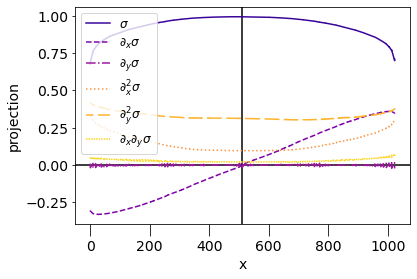

In [20]:
curve=pd.DataFrame(data)

fittings={}
for i,key in enumerate(ltrg_operators.keys()):
    p=np.polyfit(curve['x'].values,curve[key].values,2)
    fittings[key]=p

plt.rcParams.update({'font.size': 14,'legend.fontsize':12})
plt.figure(figsize=(6,4))

plt.axhline(0,color='k')
plt.axvline(511.5,color='k')

cm=plt.get_cmap('plasma')
linestyles=['-','--','-.',':',(5, (10,3)),(0, (1, .7))]
iLinestyle=0

for i,key in enumerate(ltrg_operators.keys()):
    normalized=curve[key]/curve['sig']
    normalized=curve[key]
    if(normalized.abs().max()>.01):
        # if key in fittings.keys():
        #     plt.plot(curve['x'],np.polyval(fittings[key],curve['x']),'-',color=plt.cm.rainbow(i/len(ltrg_operators)))
        plt.plot(curve['x'],curve[key],linestyle=linestyles[iLinestyle],label=op_latex[key],color=plt.cm.plasma(i/len(ltrg_operators)))
        iLinestyle=iLinestyle+1



plt.legend()
plt.xlabel('x')
plt.ylabel('projection')

plt.savefig('./figures/EncodePosition.png',dpi=300,bbox_inches='tight')
plt.show()